In [127]:
import pandas as pd
import pickle
import ledapy
import tqdm
import datetime
import neurokit2 as nk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [128]:
subject_id = 'c1s01'
# cgm_data = pd.read_pickle('../../dataset/processed/c1s01/1.pkl')
cgm_data = pd.read_pickle('../../dataset/processed/c1s01/1863.pkl')

cgm_idx = cgm_data['Index']
cgm_timestamp = cgm_data['Timestamp']
cgm_glucose = cgm_data['glucose']

In [129]:
print(cgm_data)

{'Index': 23442.0, 'Timestamp': Timestamp('2022-06-24 05:59:55'), 'glucose': 111.0, 'zephyr': {'Accel': {'Time': array(['2022-06-24T05:54:54.006000000', '2022-06-24T05:54:54.016000000',
       '2022-06-24T05:54:54.026000000', ...,
       '2022-06-24T05:59:54.976000000', '2022-06-24T05:59:54.986000000',
       '2022-06-24T05:59:54.996000000'], dtype='datetime64[ns]'), 'Vertical': array([2049, 2048, 2048, ..., 2047, 2048, 2047]), 'Lateral': array([1963, 1964, 1962, ..., 1962, 1965, 1963]), 'Sagittal': array([2063, 2063, 2062, ..., 2066, 2065, 2065])}, 'Breathing': {'Time': array(['2022-06-24T05:54:54.036000000', '2022-06-24T05:54:54.076000000',
       '2022-06-24T05:54:54.116000000', ...,
       '2022-06-24T05:59:54.916000000', '2022-06-24T05:59:54.956000000',
       '2022-06-24T05:59:54.996000000'], dtype='datetime64[ns]'), 'BreathingWaveform': array([6258115, 6259140, 6258654, ..., 6246511, 6246727, 6248023])}, 'ECG': {'Time': array(['2022-06-24T05:54:54.004000000', '2022-06-24T05:54:5

## ECG Data

In [130]:
ecg_data = cgm_data['zephyr']['ECG']
summary_data = cgm_data['zephyr']['Summary']

In [131]:
fs = 250
ecg_clean = nk.ecg_clean(ecg_data['EcgWaveform'], sampling_rate=fs)
_, rpeaks = nk.ecg_peaks(ecg_clean, sampling_rate=fs, correct_artifacts=True)
r_peaks = np.unique(rpeaks['ECG_R_Peaks'])

window_size = 3 * fs

extracted_ecg = []
for peak in tqdm.tqdm(r_peaks):
    start_idx = peak - window_size//2
    end_idx = start_idx + window_size
    try:
        start_t = ecg_data['Time'][start_idx]
        end_t = ecg_data['Time'][end_idx]
        beat_ecg = ecg_clean[start_idx:end_idx]

        if beat_ecg.shape[0] == 0:
            continue
        
        summary_window = (summary_data['Time'] >= start_t) & (summary_data['Time'] < end_t)
        avg_HRConfidence = summary_data["HRConfidence"][summary_window].mean()
        avg_ECGNoise = summary_data["ECGNoise"][summary_window].mean()

        extracted_ecg.append({
            'ecg': beat_ecg,
            'start_t': start_t,
            'end_t': end_t,
            'glucose': cgm_glucose,
            'CGM_idx': cgm_idx,
            'Timestamp': cgm_timestamp,
            'HRConfidence': avg_HRConfidence,
            'ECGNoise': avg_ECGNoise
        })
    except:
        pass

extracted_ecg = pd.DataFrame(extracted_ecg)


100%|██████████| 260/260 [00:00<00:00, 52894.17it/s]


In [132]:
clean_extracted_ecg = extracted_ecg[extracted_ecg['HRConfidence'] >= 100 & (extracted_ecg['ECGNoise'] <= 0.001)]
clean_extracted_ecg = clean_extracted_ecg.sort_values('start_t')
print(clean_extracted_ecg)

                                                   ecg  \
0    [0.17962045835556403, 0.11173597109684937, 0.0...   
1    [-0.931798423358772, -0.8055870199244989, -0.7...   
2    [-5.951469848104671, -5.601582323808806, -5.25...   
3    [-4.206199134583969, -4.182378925879566, -4.07...   
4    [-5.762826889066166, -5.782561024876836, -5.64...   
..                                                 ...   
254  [24.06589755857489, 43.20139843908406, 64.9370...   
255  [-10.896931785041403, -10.981826306427601, -11...   
256  [-3.915451866162976, -3.93457494598662, -4.073...   
257  [4.8988978567957036, 5.538627304379154, 5.9382...   
258  [-0.7749350006027601, -0.26811033839650766, 0....   

                    start_t                   end_t  glucose  CGM_idx  \
0   2022-06-24 05:54:54.016 2022-06-24 05:54:57.016    111.0  23442.0   
1   2022-06-24 05:54:55.244 2022-06-24 05:54:58.244    111.0  23442.0   
2   2022-06-24 05:54:56.528 2022-06-24 05:54:59.528    111.0  23442.0   
3   2022-06

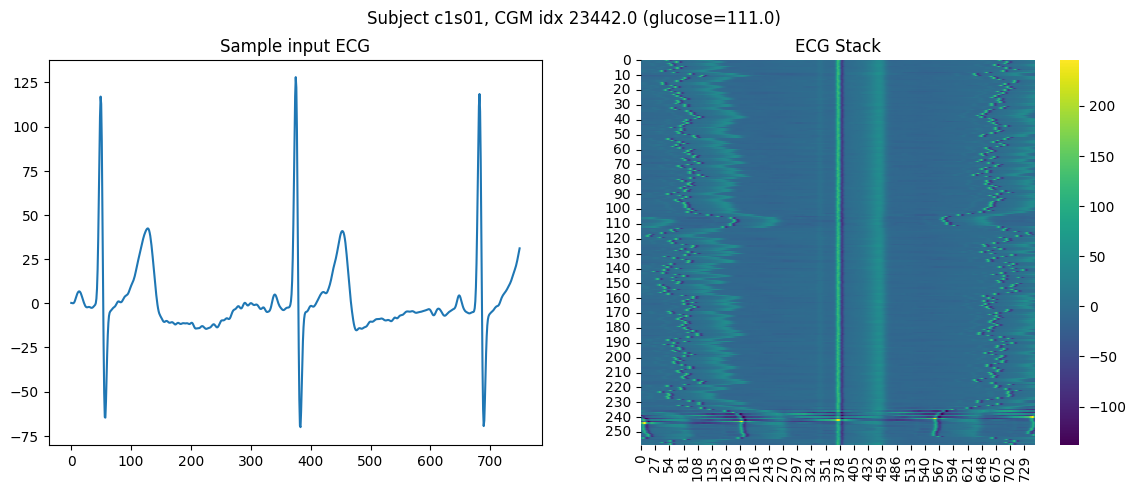

In [133]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
# for i in range(clean_extracted_ecg.shape[0]):
axs[0].plot(clean_extracted_ecg['ecg'][0])
axs[0].set_title('Sample input ECG')

heat_map = np.zeros((clean_extracted_ecg.shape[0], clean_extracted_ecg['ecg'][0].shape[0]))
for i in range(clean_extracted_ecg.shape[0]):
    heat_map[i, :] = clean_extracted_ecg['ecg'][i]

sns.heatmap(heat_map, ax=axs[1], cmap='viridis')
axs[1].set_title('ECG Stack')

fig.suptitle('Subject {}, CGM idx {} (glucose={})'.format(subject_id, cgm_idx, cgm_glucose))
plt.show()



## PPG Data

In [134]:
ppg_data = cgm_data['e4']['BVP']

In [135]:
ppg_fs = 64
ppg_clean = nk.ppg_clean(ppg_data['BVP'], sampling_rate=ppg_fs)

In [136]:
window_size = 30 * ppg_fs
overlap_ratio = 0.5

extracted_ppg = []
for i in tqdm.tqdm(range(0, ppg_data['Time'].shape[0], int(window_size * overlap_ratio))):
    try:
        start_idx = i
        end_idx = start_idx + window_size
        start_t = ppg_data['Time'][start_idx]
        end_t = ppg_data['Time'][end_idx]
        window_ppg = ppg_clean[start_idx:end_idx]

        extracted_ppg.append({
            'ppg': window_ppg,
            'start_t': start_t,
            'end_t': end_t,
            'glucose': cgm_glucose,
            'CGM_idx': cgm_idx,
            'Timestamp': cgm_timestamp,
        })
    except:
        pass

extracted_ppg = pd.DataFrame(extracted_ppg)

100%|██████████| 21/21 [00:00<00:00, 103991.01it/s]


In [137]:
print(extracted_ppg)

                                                  ppg  \
0   [-1.5844715751892786, -3.096667099820889, -4.7...   
1   [15.771010425818403, 15.173274573015863, 14.59...   
2   [7.631148935750472, 8.064897488838412, 8.63057...   
3   [3.3225439092248967, 1.9592207469117326, 0.804...   
4   [7.301613876944675, 9.039281793417157, 10.2629...   
5   [9.51444075404312, 8.538753459724207, 7.656172...   
6   [14.63780892991152, 14.35604685981757, 13.9172...   
7   [-13.180430908117552, -14.306336839372564, -15...   
8   [-1.7591275446145183, -2.558246762228456, -3.4...   
9   [9.107120462925058, 8.731209318066192, 8.65006...   
10  [12.488536492259783, 13.177182835303825, 13.56...   
11  [5.893424239303054, 5.004483284929792, 4.13479...   
12  [4.668799037345021, 5.904969070324387, 6.75566...   
13  [7.692223557988031, 8.282014692518906, 8.88583...   
14  [9.939217344824403, 10.468306012380006, 10.865...   
15  [6.826753706854404, 6.1237481945520855, 5.3408...   
16  [11.382672513968112, 12.466

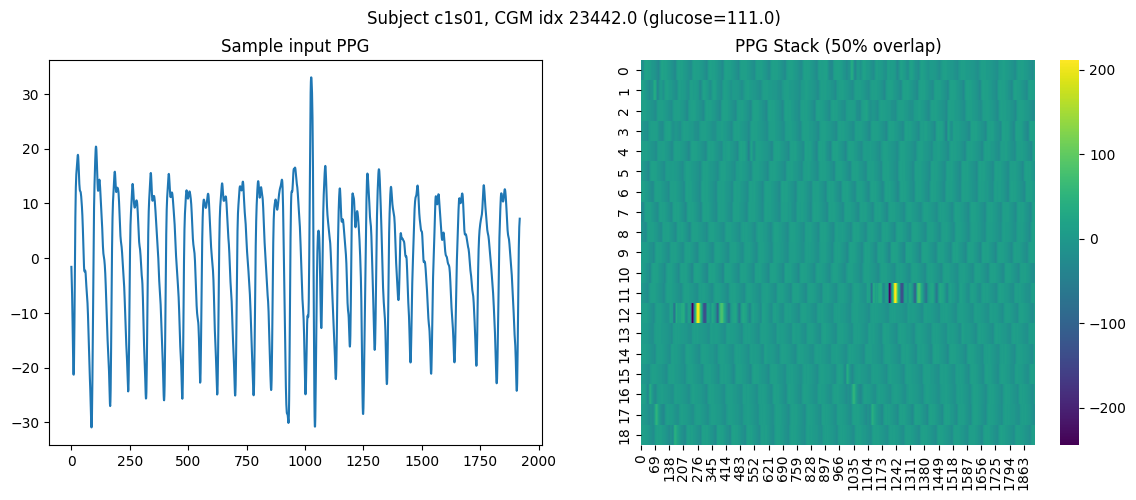

In [138]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
# for i in range(extracted_ppg.shape[0]):
#     axs[0].plot(extracted_ppg['ppg'][i])
axs[0].plot(extracted_ppg['ppg'][0])
axs[0].set_title('Sample input PPG')

heat_map = np.zeros((extracted_ppg.shape[0], extracted_ppg['ppg'][0].shape[0]))
for i in range(extracted_ppg.shape[0]):
    heat_map[i, :] = extracted_ppg['ppg'][i]

sns.heatmap(heat_map, ax=axs[1], cmap='viridis')
axs[1].set_title('PPG Stack (50% overlap)')
fig.suptitle('Subject {}, CGM idx {} (glucose={})'.format(subject_id, cgm_idx, cgm_glucose))
plt.show()

## EDA

In [145]:
eda_data = cgm_data['e4']['EDA']
eda_sample_rate = 4
uniform_timeline = pd.date_range(end=cgm_timestamp, periods=(eda_sample_rate * 60 * 5), freq=f'{int(1000 / eda_sample_rate)}ms')

original_timestamps = pd.to_datetime(eda_data['Time'])
original_values = eda_data['EDA']
ori_eda_df = pd.DataFrame({'Timestamp': original_timestamps, 'EDA': original_values})
ori_eda_df.set_index('Timestamp', inplace=True)

eda_interpolated = ori_eda_df.reindex(uniform_timeline)
# check if all zeros
if eda_interpolated['EDA'].sum() == 0:
    print('All zeros')
    raise ValueError('All zeros')
# replace NaN with mean
eda_interpolated.fillna(eda_data['EDA'].mean(), inplace=True)
phasicdata = ledapy.runner.getResult(eda_interpolated['EDA'].values, 'phasicdata', eda_sample_rate)
tonicdata = eda_interpolated['EDA'].values - phasicdata

timestamps = pd.to_datetime(eda_data['Time'])
time_deltas = (timestamps - timestamps[0]).total_seconds()
time_diff = np.diff(time_deltas)
time_diff = np.insert(time_diff, 0, np.inf)
segments_indices = np.where(time_diff > 1 / eda_sample_rate)[0]

# Extract start and end timestamps for each segment
segments = []
for i, idx in enumerate(segments_indices):
    start = timestamps[idx]
    end = timestamps[segments_indices[i + 1] - 1] if i + 1 < len(segments_indices) else timestamps[-1]
    segments.append((start, end))

extracted_eda = [{
    'phasic': phasicdata,
    'tonic': tonicdata,
    'start_t': uniform_timeline[0],
    'end_t': uniform_timeline[-1],
    'segments': segments,
    'glucose': cgm_glucose,
    'CGM_idx': cgm_idx,
    'Timestamp': cgm_timestamp,
}]
extracted_eda = pd.DataFrame(extracted_eda)

print(extracted_eda)

                                              phasic  \
0  [0.2639927301609948, 0.25246173016099505, 0.24...   

                                               tonic                 start_t  \
0  [10.548127269839005, 10.548127269839005, 10.54... 2022-06-24 05:54:55.250   

                end_t                                           segments  \
0 2022-06-24 05:59:55  [(2022-06-24 05:54:54.250000, 2022-06-24 05:59...   

   glucose  CGM_idx           Timestamp  
0    111.0  23442.0 2022-06-24 05:59:55  


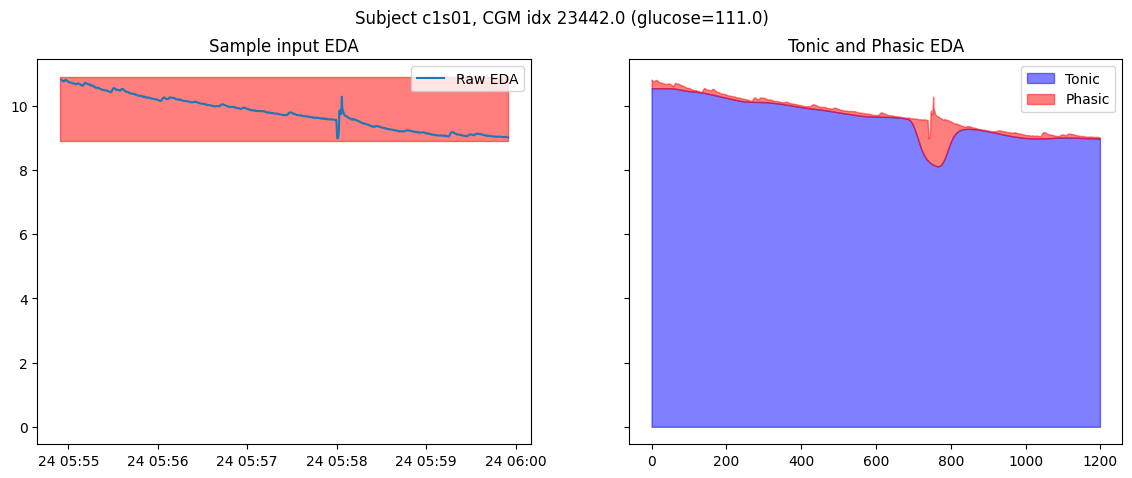

In [140]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
_extracted_data = extracted_eda.iloc[0]
raw_eda = _extracted_data['phasic'] + _extracted_data['tonic']
tonicdata = _extracted_data['tonic']
phasicdata = _extracted_data['phasic']

axs[0].plot(raw_eda, label='Raw EDA')
axs[0].legend()
axs[0].set_title('Sample input EDA')
yaxis_lim = axs[0].get_ylim()
for seg in _extracted_data['segments']:
    axs[0].fill_betweenx(yaxis_lim, seg[0], seg[1], color='red', alpha=0.5)

axs[1].fill_between(np.arange(tonicdata.shape[0]), tonicdata, color='blue', alpha=0.5, label='Tonic')
axs[1].fill_between(np.arange(phasicdata.shape[0]), tonicdata, raw_eda, color='red', alpha=0.5, label='Phasic')
axs[1].legend()
axs[1].set_title('Tonic and Phasic EDA')

fig.suptitle('Subject {}, CGM idx {} (glucose={})'.format(subject_id, cgm_idx, cgm_glucose))
plt.show()

## Temperature

In [141]:
temp_data = cgm_data['e4']['TEMP']
extracted_temp = [{
    'temp': temp_data['TEMP'].mean(),
    'start_t': temp_data['Time'][0],
    'end_t': temp_data['Time'][-1],
    'glucose': cgm_glucose,
    'CGM_idx': cgm_idx,
    'Timestamp': cgm_timestamp,
}]
extracted_temp = pd.DataFrame(extracted_temp)

print(extracted_temp)


        temp                 start_t               end_t  glucose  CGM_idx  \
0  33.835565 2022-06-24 05:54:54.250 2022-06-24 05:59:55    111.0  23442.0   

            Timestamp  
0 2022-06-24 05:59:55  
